In [14]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from typing import Dict, List, Tuple, Union

class CubeData(Dataset):
    """Cube Dataset with Stride-based Patch Extraction and Normalization"""
    def __init__(self, root: str, name: str, patch_size: int = 128, stride: int = 64, 
                 transform=None, folder=True, file=None) -> None:
        """
        Create a dataset from a given directory with stride-based patch extraction.
        
        Args:
            root (str): Root directory path
            name (str): Name of the dataset/subdirectory
            patch_size (int): Size of patches to extract (default: 128)
            stride (int): Stride for patch extraction (default: 64)
            transform: Optional transform to be applied on patches
            folder (bool): If True, load all .npy files from directory. If False, load single file
            file (str): Specific file to load when folder=False
        """
        super().__init__()
        self.transform = transform
        self.root = root
        self.name = name
        self.patch_size = patch_size
        self.stride = stride
    
        # Handle both folder and single file cases
        if folder:
            self.cubeFileNames = [f for f in os.listdir(os.path.join(self.root, name, "python")) 
                                if ".npy" in f]
        else:
            if file is None:
                raise ValueError("When folder=False, a file name must be provided!")
            self.cubeFileNames = [file]

        if len(self.cubeFileNames) == 0:
            raise ValueError("Couldn't find any numpy files in the given folder!")

        self.cubes = self.__load_cubes()
        self.patches, self.patch_positions = self.__extract_patches()
        self.file_patch_mapping = self.__create_file_patch_mapping()
        
        # Compute mean and std for normalization
        self.mean, self.std = self.__compute_mean_and_std()
        print(f"Dataset mean: {self.mean}")
        print(f"Dataset std: {self.std}")
    
    def __len__(self) -> int:
        """Returns the total number of patches."""
        return len(self.patches)

    def __compute_mean_and_std(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute mean and standard deviation directly from patches.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation for each channel
        """
        # Convert patches to torch tensors and stack them
        patches_tensor = torch.stack([torch.from_numpy(patch) for patch in self.patches])
        
        # Compute mean and std across all dimensions except the channel dimension
        # patches_tensor shape: [N, C, H, W]
        # Calculate mean across all dimensions except channels (dim 1)
        mean = patches_tensor.mean(dim=(0, 2, 3))
        
        # Calculate std across all dimensions except channels (dim 1)
        # Use unbiased=False for consistency with original implementation
        std = patches_tensor.std(dim=(0, 2, 3), unbiased=False)
        
        return mean, std

    def __load_and_reshape(self, file_path):
        """Load and reshape the cube data to ensure proper dimensionality."""
        current_cube = np.load(file_path)
        
        # Check if the array is 2D
        if current_cube.ndim == 2:
            current_cube = np.expand_dims(current_cube, axis=0).astype(np.float32)
        
        return current_cube

    def __load_cubes(self) -> Dict[str, np.ndarray]:
        """Loads all cubes contained in the folder and stores them in a dictionary indexed by filename."""
        cubes = {}
        total_size = 0
        for file in self.cubeFileNames:
            file_path = os.path.join(self.root, self.name, "python", file)
            current_cube = self.__load_and_reshape(file_path)
            fileName = file.split('.')[0]
            cubes[fileName] = current_cube
            total_size += current_cube.nbytes

        print(f"Total size of loaded cubes: {total_size / (1024**3):.2f} GB")
        return cubes

    def __extract_patches(self):
        """Extract patches from each cube using the specified patch size and stride."""
        patches = []
        patch_positions = []  # Store (file_name, xmin, xmax, ymin, ymax) for each patch
        
        for file_name, cube in self.cubes.items():
            c, H, W = cube.shape
            
            # Extract patches with stride
            for i in range(0, H - self.patch_size + 1, self.stride):
                for j in range(0, W - self.patch_size + 1, self.stride):
                    patch = cube[:, i:i+self.patch_size, j:j+self.patch_size]
                    patches.append(patch)
                    patch_positions.append((file_name, j, j+self.patch_size, i, i+self.patch_size))
                    
        return patches, patch_positions

    def __create_file_patch_mapping(self):
        """Creates a mapping of which patches belong to which file."""
        mapping = {}
        for idx, (file_name, _, _, _, _) in enumerate(self.patch_positions):
            if file_name not in mapping:
                mapping[file_name] = []
            mapping[file_name].append(idx)
        return mapping

    def _len_(self) -> int:
        """Returns the total number of patches."""
        return len(self.patches)

    def __normalize(self, patch: torch.Tensor) -> torch.Tensor:
        """Normalize the patch using computed mean and std."""
        return (patch - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-8)

    def _getitem_(self, index: Union[int, List[int], slice]) -> Tuple[torch.Tensor, torch.Tensor, Union[Dict, List[Dict]]]:
        """
        Returns normalized patch(es), corresponding mask(s), and position information.
        
        Returns:
            Tuple containing:
            - Tensor: The normalized patch(es)
            - Tensor: The mask(s)
            - Dict/List[Dict]: Position information including file name and coordinates
        """
        if isinstance(index, (torch.Tensor, np.ndarray)):
            index = index.tolist()

        if isinstance(index, int):
            patch = torch.from_numpy(self.patches[index].copy())
            position_info = {
                'file_name': self.patch_positions[index][0],
                'xmin': self.patch_positions[index][1],
                'xmax': self.patch_positions[index][2],
                'ymin': self.patch_positions[index][3],
                'ymax': self.patch_positions[index][4]
            }
            
        elif isinstance(index, list):
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in index])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in index]
            
        elif isinstance(index, slice):
            start = index.start if index.start is not None else 0
            stop = index.stop if index.stop is not None else len(self)
            step = index.step if index.step is not None else 1
            indices = range(start, stop, step)
            
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in indices])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in indices]

        # Apply normalization before other transforms
        if isinstance(patch, torch.Tensor):
            if len(patch.shape) == 3:  # Single patch
                patch = self.__normalize(patch)
            else:  # Batch of patches
                patch = torch.stack([self.__normalize(p) for p in patch])

        if self.transform:
            patch = self.transform(patch)

        mask = self.__computeMask(patch).to(torch.bool)
        patch = torch.nan_to_num(patch, nan=0.0)
        
        return patch, mask, position_info

    def __computeMask(self, img: torch.Tensor) -> torch.Tensor:
        """Computes a binary mask for a given patch."""
        mask = torch.zeros(img.shape)
        mask[torch.where(img == 0)] = 1.0

        if torch.isnan(img).any():
            mask[torch.isnan(img)] = 1.0

        if len(img.shape) == 3:
            c, h, w = img.shape
            summed = torch.sum(mask, dim=0)
            mask = torch.where(summed == c, 1.0, 0.0)[None, ...]
        else:
            n, c, h, w = img.shape
            summed = torch.sum(mask, dim=1)
            mask = torch.where(summed == c, 1.0, 0.0)[:, None, ...]

        return mask

    def get_patches_for_file(self, file_name: str) -> List[int]:
        """Returns indices of all patches that belong to a specific file."""
        file_name = file_name.replace('.npy', '')
        return self.file_patch_mapping.get(file_name, [])

Total size of loaded cubes: 0.10 GB
Dataset mean: tensor([0.0336])
Dataset std: tensor([0.0168])
Number of patches: 6105
Reconstructed image shape: (1, 3600, 7200)


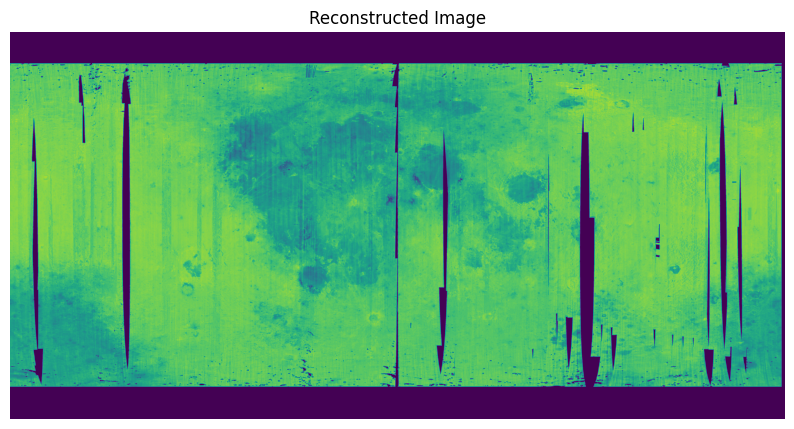

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_image(patches: np.ndarray, patch_positions: list, image_shape: tuple) -> np.ndarray:
    """
    Reconstruct the full image from the patches.

    Parameters:
    - patches: List of patches extracted from the image.
    - patch_positions: List of positions of each patch (file_name, xmin, xmax, ymin, ymax).
    - image_shape: The shape of the original image (channels, height, width).

    Returns:
    - Reconstructed image as a numpy array.
    """
    c, H, W = image_shape  # Channel, Height, Width from the original image

    # Create an empty array to hold the reconstructed image
    reconstructed_image = np.zeros((c, H, W), dtype=np.float32)
    count_matrix = np.zeros((c, H, W), dtype=np.float32)  # To count overlapping pixels

    # Reconstruct the image using patch positions
    for idx, patch in enumerate(patches):
        _, xmin, xmax, ymin, ymax = patch_positions[idx]  # Extract the position (ignore file_name)
        reconstructed_image[:, ymin:ymax, xmin:xmax] += patch
        count_matrix[:, ymin:ymax, xmin:xmax] += 1

    # Avoid division by zero
    count_matrix[count_matrix == 0] = 1
    reconstructed_image /= count_matrix

    return reconstructed_image


def plot_reconstructed_image(image: np.ndarray):
    """Plot the reconstructed image."""
    plt.figure(figsize=(10, 10))
    if image.shape[0] == 1:  # Grayscale image (single channel)
        plt.imshow(image[0])
    else:  # Multi-channel image, display the first channel
        plt.imshow(image[0])  # Change index for different channels
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
# Initialize your CubeData dataset
    data = CubeData(
            root="/work/pi_mparente_umass_edu/data/NormalizedLunarData/",
            name="geochemical_maps",
            patch_size=128,
            stride=64,
        folder = False,
        file='Global20ppd_MLR_LPGRS_geotiffCa.npy'
        )

    print(f"Number of patches: {len(data)}")

    # Extract patches and positions
    patches = data.patches
    patch_positions = data.patch_positions

    # Get the shape of the original image from one of the cubes
    first_cube = list(data.cubes.values())[0]
    image_shape = first_cube.shape  # (channels, height, width)

    # Reconstruct the image
    reconstructed_image = reconstruct_image(patches, patch_positions, image_shape)
    print(f"Reconstructed image shape: {reconstructed_image.shape}")

    # Plot the reconstructed image
    plot_reconstructed_image(reconstructed_image)


In [ ]:
next(iter(data_loader))[1].shape

In [ ]:
# Initialize DataLoader
from torch.utils.data import DataLoader


data_loader = DataLoader(data, batch_size=10, shuffle=False)


In [ ]:
# import tqdm

# def run_inference_and_reconstruct(model, data_loader):
#     """Run inference on the dataset and reconstruct the image."""
#     model.eval()  # Set model to evaluation mode
#     all_patches = []
#     all_patch_positions = []

#     with torch.no_grad():
#         for batch in tqdm.tqdm(data_loader, desc="Inference"):  # We ignore the masks for now
#             # Move to the appropriate device if using CPU
#             batch = [x.cpu() for x in batch]  # or use .to(device) if defined
#             _, _, _, _, _, recon, _ = model(batch[0], batch[1])  # Forward pass
            
#             all_patches.append(recon.cpu().numpy())  # Store patches
#             # Store positions, assuming they are in data
#             all_patch_positions.extend(data.patch_positions)  # Assuming you have this list

#     # Concatenate all patches
#     all_patches = np.concatenate(all_patches, axis=0)
#     return all_patches, all_patch_positions

In [ ]:
len(patches)

In [ ]:

# Model Inference and Evaluation
def evaluate_model(model, data_loader, device):
    model.eval()
    losses = []
    reconstructed_patches = []
    patch_positions = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating Model"):
            patches, masks = batch
            patches = patches.to(device)
            masks = masks.to(device)  # Move masks to the correct device
            spat_recon_loss, _, _, _, _, reconstructed, _ = model(patches, masks)
            losses.append(spat_recon_loss.item())
            reconstructed_patches.append(reconstructed.cpu().numpy())
            patch_positions.extend(data.patch_positions)
    reconstructed_patches = np.concatenate(reconstructed_patches, axis=0)
    return losses, reconstructed_patches, patch_positions

In [ ]:
from main import MAEPreTrainer
trainer = MAEPreTrainer(
    config=load_config('config_ti.yaml')
)
checkpoint = torch.load('/work/tpanambur_umass_edu/Experiments/Algorithm/Moon/fdl/H3Tokenizer/v1/Ti_tokens/mae-epoch=07-val_loss=1.14.ckpt', map_location='cuda')
trainer.load_state_dict(checkpoint['state_dict'])
model = trainer.model

In [ ]:
from pytorch_lightning import Trainer

# Create a Trainer instance
trainer = Trainer(
    max_epochs=10,  # Set the number of epochs
    accelerator='cpu',  # Use 1 GPU (or 0 for CPU)
    # Other Trainer arguments...
)
model.trainer = trainer

In [ ]:
reconstructed_patches, patch_positions = run_inference_and_reconstruct(model.model, data_loader)

# Get the shape of the original image from one of the cubes
first_cube = list(data.cubes.values())[0]
image_shape = first_cube.shape  # (channels, height, width)

# Reconstruct the full image
reconstructed_image = reconstruct_image(reconstructed_patches, patch_positions, image_shape)
print(f"Reconstructed image shape: {reconstructed_image.shape}")

# Plot the reconstructed image
plot_reconstructed_image(reconstructed_image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os

In [ ]:
pths = os.listdir('/work/pi_mparente_umass_edu/data/LunarData/IBD3_tokenizer/python/')

In [ ]:
arr = []
for ele in pths:
    arr.append(np.load('/work/pi_mparente_umass_edu/data/LunarData/IBD3_tokenizer/python/'+ele))

In [ ]:
for ele in arr:
    plt.imshow(ele)
    plt.show()

In [ ]:
arr[0][np.isnan(arr[0])] = 0

In [ ]:
plt.imshow(arr[0])

In [ ]:
plt.imshow(arr[0],'gray')

In [ ]:
arr[0][(arr[0]<10000)]

In [ ]:
arr[0]

Total size of loaded cubes: 1.06 GB
Loading pretrained DiVAE model from: EPFL-VILAB/4M_tokenizers_rgb_16k_224-448
DiVAE model loaded successfully.


Select an option:
1 - Plot reconstruction from checkpoint
2 - Resume evaluation from checkpoint
3 - Evaluate from scratch
Enter your choice:  1


✅ Loaded checkpoint from reconstruction_checkpoint.pkl
- Number of reconstructed patches: 47000
- Number of patch positions: 315628500
- Number of losses: 4700
- Batch counter: 0


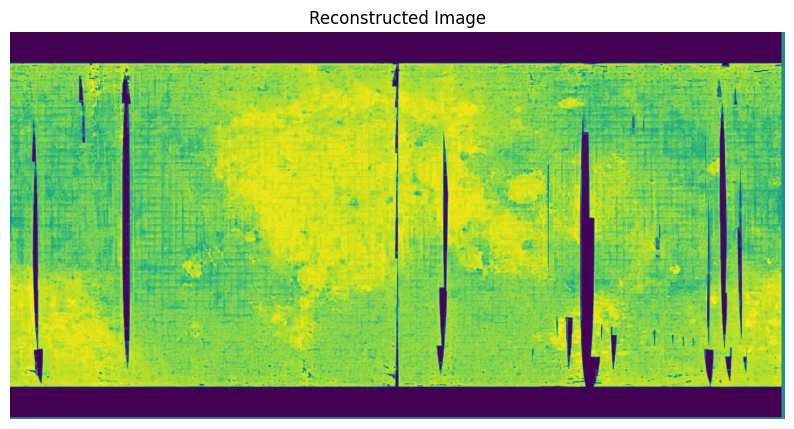

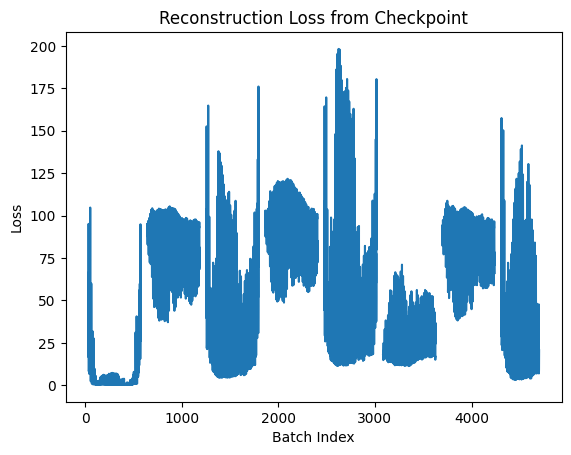

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import tqdm
import yaml
import matplotlib.pyplot as plt
from models.ml_4m.fourm.vq.vqvae import DiVAE
from model_spat import SpatialModel

from typing import Dict, List, Tuple
import pickle  # For saving intermediate results

# Config File
config = {
    'model': {
        'patch_size': 16,
        'image_size': 224,  # Ensure this is set to 224
        'use_ckpt': True,
        'num_tokens': 36,
        'num_channels': 1,  # Set to 3 for RGB input
        'enc_mask': 0.0,
        'enc_dim': 768,
        'mask_ratio': 0.0,
        'ckpt': '/home/kraju_umass_edu/Tokenizer/H3Tokenizer/models/hypersigma_weights/spat-vit-base-ultra-checkpoint-1599.pth',
        'spat_spec': False,
        'out_conv': True,
        'drop_path_rate': 0.0,
        'out_conv_type': 1,
        'use_diffusion': True,
        'use_conditioning': False,
        'scheduler_type': 'ddim',
    },
    'quantizer': {
        'quant_type': 'lucid',
        'latent_dim': 768,
        'codebook_size': 8192,
        'num_codebooks': 1,
        'norm_codes': True,
        'threshold_ema_dead_code': 32.0,
        'code_replacement_policy': 'batch_random',
        'sync_codebook': False,
        'ema_decay': 0.99,
        'commitment_weight': 0.25,
        'norm_latents': True,
        'kmeans_init': False,
    },
    'debug': True,
    'loss': {
        'norm_pix_loss': False,
        'use_percept': True,
        'model_id': 'vit_base_patch16_224.dino',  # Updated to the new mapping
        'feature_ids': 'blocks.2-blocks.5-blocks.8-blocks.11',
    },
    'scheduler': {
        'num_train_timesteps': 1000,
        'beta_schedule': "linear",
    },
}

# Function to load a saved checkpoint
def load_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)
        print(f"✅ Loaded checkpoint from {checkpoint_path}")
        print(f"- Number of reconstructed patches: {len(checkpoint['reconstructed_patches'])}")
        print(f"- Number of patch positions: {len(checkpoint['patch_positions'])}")
        print(f"- Number of losses: {len(checkpoint['losses'])}")
        print(f"- Batch counter: {checkpoint.get('batch_counter', 0)}")
        return checkpoint
    else:
        print(f"⚠️ No checkpoint found at {checkpoint_path}. Starting from scratch.")
        return {"reconstructed_patches": [], "patch_positions": [], "losses": [], "batch_counter": 0}


def evaluate_model(model, data_loader, device, checkpoint_path="checkpoint.pkl", save_every=500):
    model.eval()
    
    # Load checkpoint if it exists
    checkpoint = load_checkpoint(checkpoint_path)
    losses = checkpoint["losses"]
    reconstructed_patches = checkpoint["reconstructed_patches"]
    patch_positions = checkpoint["patch_positions"]
    batch_counter = checkpoint.get("batch_counter", 0)  # Default to 0 if not found

    # Resume from the saved batch index
    with torch.no_grad():
        for batch_index, batch in enumerate(tqdm.tqdm(data_loader, desc="Evaluating Model")):
            # Skip already processed batches
            if batch_index < batch_counter:
                continue
            
            patches, masks = batch
            patches = patches.to(device)
            masks = masks.to(device)
            
            # Forward pass through the model
            spat_recon_loss, _, _, _, _, reconstructed, _ = model(patches, masks)
            
            # Save the loss
            losses.append(spat_recon_loss.item())
            
            # Save reconstructed patches
            reconstructed_patches.append(reconstructed.cpu().numpy())
            
            # Save patch positions
            patch_positions.extend(data.patch_positions)

            # Increment batch counter
            batch_counter += 1

            # Save intermediate results periodically
            if batch_counter % save_every == 0:
                save_checkpoint(
                    {
                        "reconstructed_patches": np.concatenate(reconstructed_patches, axis=0),
                        "patch_positions": patch_positions,
                        "losses": losses,
                        "batch_counter": batch_counter,
                    },
                    checkpoint_path
                )

    # Save final checkpoint after completing all batches
    save_checkpoint(
        {
            "reconstructed_patches": np.concatenate(reconstructed_patches, axis=0),
            "patch_positions": patch_positions,
            "losses": losses,
            "batch_counter": batch_counter,
        },
        checkpoint_path
    )

    reconstructed_patches = np.concatenate(reconstructed_patches, axis=0)
    return losses, reconstructed_patches, patch_positions

# Main Script
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = CubeData(
        root="/work/pi_mparente_umass_edu/data/LunarData/",
        name="geochemical_maps",
        patch_size=128,
        stride=64
    )
    data_loader = DataLoader(data, batch_size=10, shuffle=False)
    model = SpatialModel(config).to(device)

    # Define the checkpoint path
    checkpoint_path = "reconstruction_checkpoint.pkl"

    # User choice: What to do with the checkpoint
    user_input = input("Select an option:\n"
                       "1 - Plot reconstruction from checkpoint\n"
                       "2 - Resume evaluation from checkpoint\n"
                       "3 - Evaluate from scratch\n"
                       "Enter your choice: ")

    if user_input == "1":
        # Load the checkpoint and visualize reconstruction
        checkpoint = load_checkpoint(checkpoint_path)
        if len(checkpoint["reconstructed_patches"]) > 0 and len(checkpoint["patch_positions"]) > 0:
            reconstructed_patches = np.array(checkpoint["reconstructed_patches"])
            patch_positions = checkpoint["patch_positions"]
            losses = checkpoint["losses"]

            # Reconstruct and visualize the image
            first_cube = list(data.cubes.values())[0]
            image_shape = first_cube.shape
            reconstructed_image = reconstruct_image(reconstructed_patches, patch_positions, image_shape)
            plot_reconstructed_image(reconstructed_image)

            # Plot losses
            if len(losses) > 0:
                plt.plot(losses)
                plt.title("Reconstruction Loss from Checkpoint")
                plt.xlabel("Batch Index")
                plt.ylabel("Loss")
                plt.show()
        else:
            print("Checkpoint is empty or incomplete. Cannot plot reconstruction.")


    elif user_input == "2":
        # Resume evaluation from checkpoint
        print("Resuming evaluation from checkpoint...")
        losses, reconstructed_patches, patch_positions = evaluate_model(
            model, data_loader, device, checkpoint_path=checkpoint_path, save_every=100
        )

        # Plot losses
        plt.plot(losses)
        plt.title("Reconstruction Loss Across Patches")
        plt.xlabel("Batch Index")
        plt.ylabel("Loss")
        plt.show()

        # Reconstruct and visualize the image
        first_cube = list(data.cubes.values())[0]
        image_shape = first_cube.shape
        reconstructed_image = reconstruct_image(reconstructed_patches, patch_positions, image_shape)
        plot_reconstructed_image(reconstructed_image)

    elif user_input == "3":
        # Start evaluation from scratch
        print("Starting evaluation from scratch...")
        losses, reconstructed_patches, patch_positions = evaluate_model(
            model, data_loader, device, checkpoint_path=checkpoint_path, save_every=100
        )

        # Plot losses
        plt.plot(losses)
        plt.title("Reconstruction Loss Across Patches")
        plt.xlabel("Batch Index")
        plt.ylabel("Loss")
        plt.show()

        # Reconstruct and visualize the image
        first_cube = list(data.cubes.values())[0]
        image_shape = first_cube.shape
        reconstructed_image = reconstruct_image(reconstructed_patches, patch_positions, image_shape)
        plot_reconstructed_image(reconstructed_image)
    else:
        print("Invalid choice. Please select 1, 2, or 3.")


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from models.ml_4m.fourm.vq.vqvae import VQVAE, DiVAE  # Import VQVAE and DiVAE
from model_spat import SpatialModel

# Config for DiVAE
config_divae = {
    'model': {
        'patch_size': 16,
        'image_size': 224,
        'use_ckpt': True,
        'num_tokens': 36,
        'num_channels': 1,
        'enc_mask': 0.0,
        'enc_dim': 768,
        'mask_ratio': 0.0,
        'ckpt': '/home/kraju_umass_edu/Tokenizer/H3Tokenizer/models/hypersigma_weights/spat-vit-base-ultra-checkpoint-1599.pth',
        'spat_spec': False,
        'out_conv': True,
        'drop_path_rate': 0.0,
        'out_conv_type': 1,
        'use_diffusion': True,
        'use_conditioning': False,
        'scheduler_type': 'ddim',
    },
    'quantizer': {
        'quant_type': 'lucid',
        'latent_dim': 768,
        'codebook_size': 8192,
        'num_codebooks': 1,
        'norm_codes': True,
        'threshold_ema_dead_code': 32.0,
        'code_replacement_policy': 'batch_random',
        'sync_codebook': False,
        'ema_decay': 0.99,
        'commitment_weight': 0.25,
        'norm_latents': True,
        'kmeans_init': False,
    },
    'debug': True,
    'loss': {
        'norm_pix_loss': False,
        'use_percept': True,
        'model_id': 'vit_base_patch16_224.dino',
        'feature_ids': 'blocks.2-blocks.5-blocks.8-blocks.11',
    },
    'scheduler': {
        'num_train_timesteps': 1000,
        'beta_schedule': "linear",
    },
}

# Dataset
class CubeData(Dataset):
    def __init__(self, root: str, name: str, patch_size: int = 128, stride: int = 64) -> None:
        super().__init__()
        self.root = root
        self.name = name
        self.patch_size = patch_size
        self.stride = stride
        self.cubeFileNames = [f for f in os.listdir(os.path.join(self.root, name, "python")) if ".npy" in f]
        if len(self.cubeFileNames) == 0:
            raise ValueError("Couldn't find any numpy files in the given folder!")
        self.cubes = self.__load_cubes()
        self.patches, self.patch_positions = self.__extract_patches()

    def __load_cubes(self) -> dict:
        cubes = {}
        for file in self.cubeFileNames:
            file_path = os.path.join(self.root, self.name, "python", file)
            current_cube = np.load(file_path)
            if current_cube.ndim == 2:
                current_cube = np.expand_dims(current_cube, axis=0).astype(np.float32)
            cubes[file.split('.')[0]] = current_cube
        return cubes
    
    def __extract_patches(self):
        patches, patch_positions = [], []
        for cube in self.cubes.values():
            c, H, W = cube.shape
            for i in range(0, H - self.patch_size + 1, self.stride):
                for j in range(0, W - self.patch_size + 1, self.stride):
                    patches.append(cube[:, i:i+self.patch_size, j:j+self.patch_size])
                    patch_positions.append((j, j+self.patch_size, i, i+self.patch_size))
        return patches, patch_positions
    
    def __len__(self):
        return len(self.patches)

    def __getitem__(self, index: int):
        return torch.from_numpy(self.patches[index])

# Reconstruction Utility
def reconstruct_image(patches: np.ndarray, patch_positions: list, image_shape: tuple) -> np.ndarray:
    c, H, W = image_shape
    reconstructed_image = np.zeros((c, H, W), dtype=np.float32)
    count_matrix = np.zeros((c, H, W), dtype=np.float32)
    for idx, patch in enumerate(patches):
        xmin, xmax, ymin, ymax = patch_positions[idx]
        reconstructed_image[:, ymin:ymax, xmin:xmax] += patch
        count_matrix[:, ymin:ymax, xmin:xmax] += 1
    count_matrix[count_matrix == 0] = 1
    reconstructed_image /= count_matrix
    return reconstructed_image

# Plotting Function
def plot_comparison(original_image, reconstructed_divae, reconstructed_vqvae, title="Comparison of Models"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_image[0], cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(reconstructed_divae[0], cmap='gray')
    axes[1].set_title("Reconstructed: DiVAE")
    axes[1].axis('off')

    axes[2].imshow(reconstructed_vqvae[0], cmap='gray')
    axes[2].set_title("Reconstructed: VQVAE")
    axes[2].axis('off')

    plt.suptitle(title)
    plt.show()

# Evaluation Function
def evaluate_models(divae_model, vqvae_model, data_loader, device):
    divae_model.eval()
    vqvae_model.eval()

    reconstructed_divae_patches = []
    reconstructed_vqvae_patches = []

    with torch.no_grad():
        for patches in tqdm.tqdm(data_loader, desc="Evaluating Models"):
            patches = patches.to(device)
            # DiVAE Inference
            _, _, _, _, _, divae_reconstructed, _ = divae_model(patches, nan_mask=None)
            reconstructed_divae_patches.append(divae_reconstructed.cpu().numpy())
            # VQVAE Inference
            vqvae_reconstructed = vqvae_model(patches)
            reconstructed_vqvae_patches.append(vqvae_reconstructed.cpu().numpy())

    reconstructed_divae_patches = np.concatenate(reconstructed_divae_patches, axis=0)
    reconstructed_vqvae_patches = np.concatenate(reconstructed_vqvae_patches, axis=0)

    return reconstructed_divae_patches, reconstructed_vqvae_patches

# Main
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load Dataset
    data = CubeData(
        root="/work/pi_mparente_umass_edu/data/LunarData/",
        name="geochemical_maps",
        patch_size=128,
        stride=64
    )
    data_loader = DataLoader(data, batch_size=10, shuffle=False)

    # Load Models
    divae_model = SpatialModel(config_divae).to(device)
    vqvae_model = VQVAE(num_channels=1, latent_dim=768, num_embeddings=8192).to(device)

    # Evaluate Models
    reconstructed_divae, reconstructed_vqvae = evaluate_models(divae_model, vqvae_model, data_loader, device)

    # Reconstruct Image
    first_cube = list(data.cubes.values())[0]
    image_shape = first_cube.shape
    reconstructed_divae_image = reconstruct_image(reconstructed_divae, data.patch_positions, image_shape)
    reconstructed_vqvae_image = reconstruct_image(reconstructed_vqvae, data.patch_positions, image_shape)

    # Plot Comparison
    plot_comparison(first_cube, reconstructed_divae_image, reconstructed_vqvae_image)
